In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [3]:
# For some reason these things don't stick if they're in the same cell as the
# %matplotlib inline call above, but if they're separate, they work fine.
sns.set()
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 56

In [4]:
start_year = 2011
end_year = 2017
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])

pudl_out_ferc1 = pudl.output.pudltabl.PudlTabl(pudl_engine=pudl_engine)
steam_ferc1 = (
    pudl_out_ferc1.plants_steam_ferc1().
    query("report_year>=@start_year and report_year<=@end_year")
)
fuel_ferc1 = (
    pudl_out_ferc1.fuel_ferc1().
    drop_duplicates(subset=['record_id']).
    query("report_year>=@start_year and report_year<=@end_year")
)

pudl_out_eia = pudl.output.pudltabl.PudlTabl(pudl_engine=pudl_engine, freq="AS")
mcoe_df = pudl_out_eia.mcoe()

/home/zane/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [5]:
nf = pudl.transform.ferc1.fuel_by_plant_ferc1(fuel_ferc1)
nf.sample(10)

,utility_id_ferc1,plant_name_ferc1,report_year,coal_fraction_mmbtu,gas_fraction_mmbtu,nuclear_fraction_mmbtu,oil_fraction_mmbtu,other_fraction_mmbtu,waste_fraction_mmbtu,fuel_mmbtu,coal_fraction_cost,gas_fraction_cost,nuclear_fraction_cost,oil_fraction_cost,other_fraction_cost,waste_fraction_cost,fuel_cost,primary_fuel_by_mmbtu,primary_fuel_by_cost
2733,134,naughton,2012,0.998267,0.001733,0.0,0.000000,0.0,0.000000,5.392630e+07,0.991403,0.008597,0.0,0.000000,0.0,0.0,1.058020e+08,coal,coal
5092,432,wn clark,2011,0.999996,0.000000,0.0,0.000000,0.0,0.000004,3.358324e+06,1.000000,0.000000,0.0,0.000000,0.0,0.0,9.873417e+06,coal,coal
3358,159,williams combined,2017,0.000000,0.967460,0.0,0.032540,0.0,0.000000,4.996473e+04,0.000000,0.880186,0.0,0.119814,0.0,0.0,1.657679e+05,gas,gas
869,44,st. clair,2011,0.000000,0.716343,0.0,0.283657,0.0,0.000000,5.105133e+03,0.000000,0.411976,0.0,0.588024,0.0,0.0,5.410616e+04,gas,oil
3464,164,*pirkey (2),2013,0.998147,0.001853,0.0,0.000000,0.0,0.000000,4.563229e+07,0.997365,0.002635,0.0,0.000000,0.0,0.0,1.369414e+08,coal,coal
1928,89,m34/marinette,2011,0.000000,1.000000,0.0,0.000000,0.0,0.000000,4.368970e+04,0.000000,1.000000,0.0,0.000000,0.0,0.0,2.437790e+05,gas,gas
90,6,mountaineer,2015,0.997691,0.000000,0.0,0.002309,0.0,0.000000,7.503765e+07,0.979766,0.000000,0.0,0.020234,0.0,0.0,1.642903e+08,coal,coal
24,2,barry,2016,1.000000,0.000000,0.0,0.000000,0.0,0.000000,4.405954e+07,1.000000,0.000000,0.0,0.000000,0.0,0.0,1.595305e+08,coal,coal
2797,144,cayuga ct,2015,0.000000,1.000000,0.0,0.000000,0.0,0.000000,1.046270e+05,0.000000,1.000000,0.0,0.000000,0.0,0.0,3.170198e+05,gas,gas
4000,186,clover,2014,0.999517,0.000000,0.0,0.000483,0.0,0.000000,2.843909e+07,0.996912,0.000000,0.0,0.003088,0.0,0.0,8.991775e+07,coal,coal


In [6]:
key_cols = [
    'report_year',
    'utility_id_ferc1',
    'plant_name_ferc1',
]
ferc1_plants = (
    pd.merge(nf, steam_ferc1, on=key_cols, how='inner').
    assign(heat_rate_mmbtu_mwh=lambda x: x.fuel_mmbtu / x.net_generation_mwh).
    merge(steam_ferc1[key_cols+['utility_id_pudl', 'utility_name_ferc1','plant_id_pudl', 'plant_id_ferc1']]).
    query(f'report_year >= {start_year}')
)
ferc1_coal_plants = ferc1_plants.query("primary_fuel_by_mmbtu=='coal'")
ferc1_gas_plants = ferc1_plants.query("primary_fuel_by_mmbtu=='gas'")

eia_plants = mcoe_df.assign(report_year=lambda x: x.report_date.dt.year)
eia_coal_plants = eia_plants.query("fuel_type_code_pudl=='coal'")
eia_gas_plants = eia_plants.query("fuel_type_code_pudl=='gas'")

/home/zane/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/zane/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


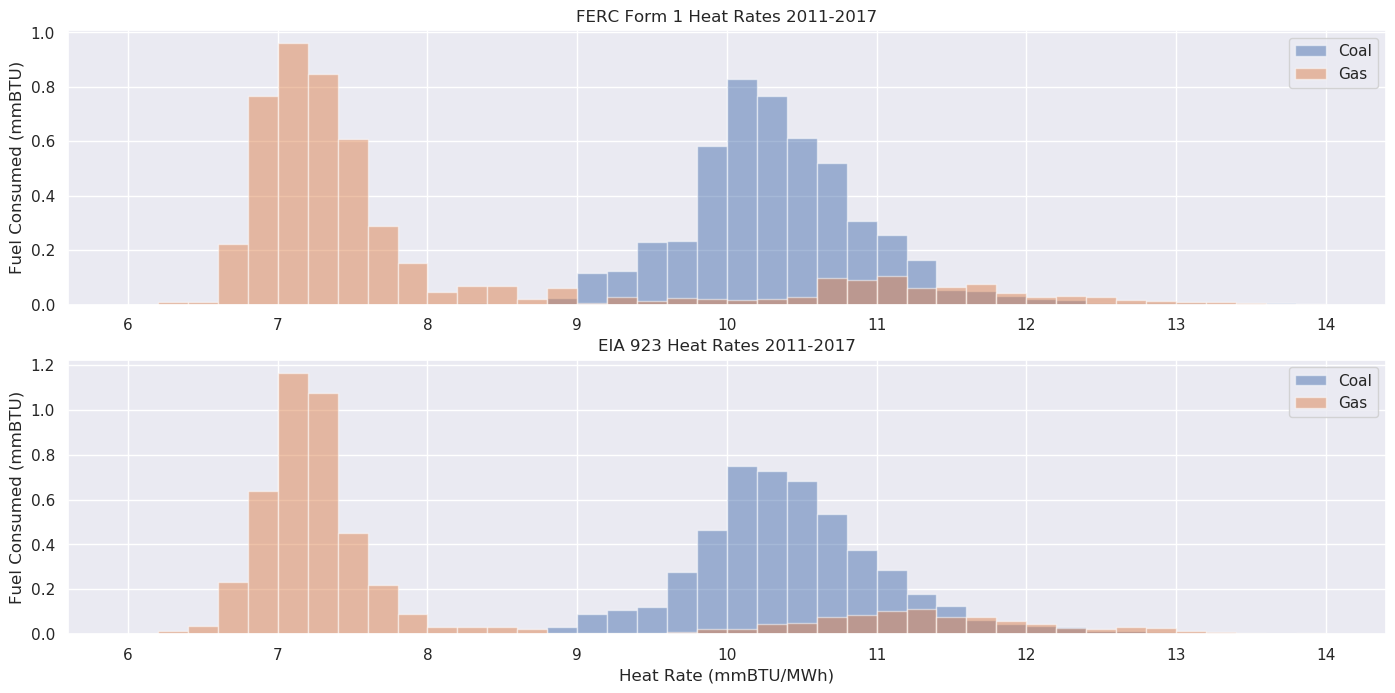

In [7]:
fig, (ferc1_ax, eia_ax) = plt.subplots(ncols=1, nrows=2, figsize=(17,8))
ylabel = "Fuel Consumed (mmBTU)"
xlabel = "Heat Rate (mmBTU/MWh)"
hr_range = (6,14)
nbins=40
pdf=True

ferc1_ax.hist(ferc1_coal_plants.heat_rate_mmbtu_mwh,
             weights=ferc1_coal_plants.net_generation_mwh, alpha=0.5,
             label="Coal", density=pdf, range=hr_range, bins=nbins)
ferc1_ax.hist(ferc1_gas_plants.heat_rate_mmbtu_mwh,
             weights=ferc1_gas_plants.net_generation_mwh, alpha=0.5,
             label="Gas", density=pdf, range=hr_range, bins=nbins)
ferc1_ax.set_ylabel(ylabel)
ferc1_ax.set_title(f"FERC Form 1 Heat Rates {start_year}-{end_year}")
ferc1_ax.legend()

eia_ax.hist(eia_coal_plants.heat_rate_mmbtu_mwh,
            weights=eia_coal_plants.net_generation_mwh, alpha=0.5,
            label="Coal", density=pdf, range=hr_range, bins=nbins)
eia_ax.hist(eia_gas_plants.heat_rate_mmbtu_mwh,
            weights=eia_gas_plants.net_generation_mwh, alpha=0.5,
            label="Gas", density=pdf, range=hr_range, bins=nbins)
eia_ax.set_ylabel(ylabel)
eia_ax.set_xlabel(xlabel)
eia_ax.set_title(f"EIA 923 Heat Rates {start_year}-{end_year}")
eia_ax.legend()

plt.show()

## Comparing FERC & EIA Fuel Costs (\$/MWh), Grouped by PUDL Plant + Fuel

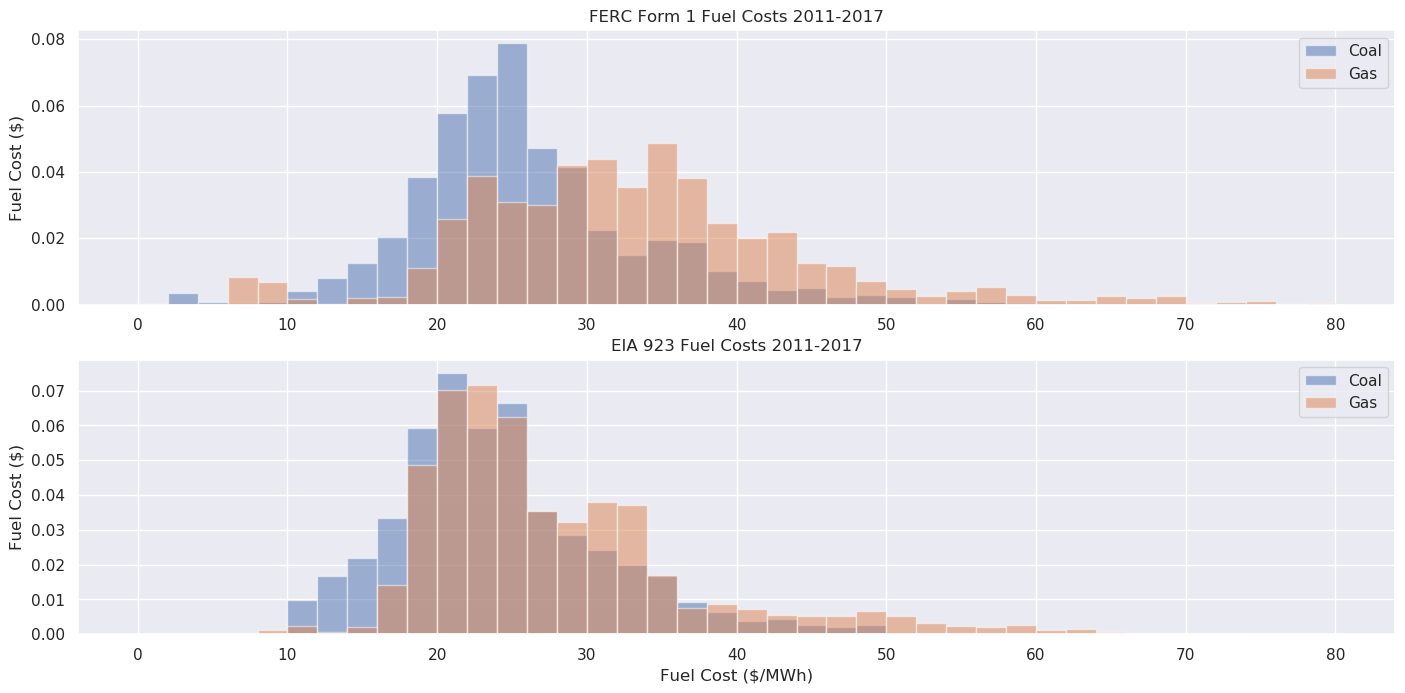

In [8]:
fig, (ferc1_ax, eia_ax) = plt.subplots(ncols=1, nrows=2, figsize=(17,8))
xlabel = "Fuel Cost ($/MWh)"
ylabel = "Fuel Cost ($)"
cost_range = (0,80)
nbins=40
pdf=True

ferc1_ax.hist((ferc1_coal_plants.opex_fuel/ferc1_coal_plants.net_generation_mwh), range=cost_range, bins=nbins, weights=ferc1_coal_plants.net_generation_mwh, label="Coal", density=pdf, alpha=0.5)
ferc1_ax.hist((ferc1_gas_plants.opex_fuel/ferc1_gas_plants.net_generation_mwh), range=cost_range, bins=nbins, weights=ferc1_gas_plants.net_generation_mwh, label="Gas", density=pdf, alpha=0.5)
ferc1_ax.set_ylabel(ylabel)
ferc1_ax.set_title(f"FERC Form 1 Fuel Costs {start_year}-{end_year}")
ferc1_ax.legend()

eia_ax.hist((eia_coal_plants.fuel_cost_per_mwh), range=cost_range, bins=nbins, weights=eia_coal_plants.net_generation_mwh, label="Coal", density=pdf, alpha=0.5)
eia_ax.hist((eia_gas_plants.fuel_cost_per_mwh), range=cost_range, bins=nbins, weights=eia_gas_plants.net_generation_mwh, label="Gas", density=pdf, alpha=0.5)
eia_ax.set_ylabel(ylabel)
eia_ax.set_xlabel(xlabel)
eia_ax.set_title(f"EIA 923 Fuel Costs {start_year}-{end_year}")
eia_ax.legend()

plt.show()

## PUDL Plant + Fuel Level EIA/FERC Agreement in Annual Heat Rates
 * Merge FERC & MCOE on [`report_year`, `fuel_type_code_pudl`, `plant_id_pudl`]
 
Stuff to plot (Annual):
 * Total Fuel Cost (\$)
 * Total Heat Content (mmBTU)
 * Total Net Generation (MWh)
 * Total Capacity (MW)
 * Fuel Cost (\$/MWh)
 * Fuel Cost (\$/mmBTU)
 * Heat Rate (mmBTU/MWh)
 * Capacity Factor

In [9]:
pudl_plant_cols = [
    'plant_id_pudl',
    'primary_fuel_by_mmbtu',
    'report_year',
]
eia_dude = (
    eia_plants.
    rename(columns={'total_fuel_cost': 'opex_fuel',
                    'fuel_type_code_pudl': 'primary_fuel_by_mmbtu'}).
    groupby(pudl_plant_cols)['net_generation_mwh',
                             'capacity_mw',
                             'opex_fuel',
                             'total_mmbtu'].
    agg(sum).reset_index().
    assign(fuel_cost_per_mwh=lambda x: x.opex_fuel / x.net_generation_mwh).
    assign(fuel_cost_per_mmbtu=lambda x: x.opex_fuel / x.total_mmbtu).
    assign(heat_rate_mmbtu_mwh=lambda x: x.total_mmbtu / x.net_generation_mwh).
    assign(capacity_factor=lambda x: x.net_generation_mwh / (8760*x.capacity_mw))
)
ferc1_dude = (
    ferc1_plants.
    rename(columns={'fuel_mmbtu': 'total_mmbtu'}).
    groupby(pudl_plant_cols)['net_generation_mwh',
                             'capacity_mw',
                             'opex_fuel',
                             'opex_production_total',
                             'total_mmbtu'].
    agg(sum).reset_index().
    assign(opex_nonfuel_ferc=lambda x: x.opex_production_total - x.opex_fuel).
    drop('opex_production_total', axis=1).
    assign(fuel_cost_per_mwh=lambda x: x.opex_fuel / x.net_generation_mwh).
    assign(fuel_cost_per_mmbtu=lambda x: x.opex_fuel / x.total_mmbtu).
    assign(heat_rate_mmbtu_mwh=lambda x: x.total_mmbtu / x.net_generation_mwh).
    assign(capacity_factor=lambda x: x.net_generation_mwh / (8760*x.capacity_mw))
)
pudl_dude = pd.merge(ferc1_dude, eia_dude, suffixes=('_ferc1', '_eia'), on=pudl_plant_cols)

In [10]:
def plot_eia_v_ferc1(df, fields_to_plot, xy_limits):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    for field in fields_to_plot:
        field_eia = field+'_eia'
        field_ferc1 = field+'_ferc1'
        fig, (coal_ax, gas_ax) = plt.subplots(ncols=2, nrows=1, figsize=(17, 8))
        
        coal_ax.scatter(df.query("primary_fuel_by_mmbtu=='coal'")[field_eia],
                        df.query("primary_fuel_by_mmbtu=='coal'")[field_ferc1],
                        color='black', alpha='0.1', label=field)
        coal_ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
        coal_ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
        coal_ax.set_xlabel('EIA')
        coal_ax.set_ylabel('FERC Form 1')
        coal_ax.set_title(f"{field} (Coal)")
        
        gas_ax.scatter(df.query("primary_fuel_by_mmbtu=='gas'")[field_eia],
                       df.query("primary_fuel_by_mmbtu=='gas'")[field_ferc1],
                       color='blue', alpha='0.1', label=field)
        gas_ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
        gas_ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
        gas_ax.set_xlabel('EIA')
        gas_ax.set_ylabel('FERC Form 1')
        gas_ax.set_title(f"{field} (Gas)")

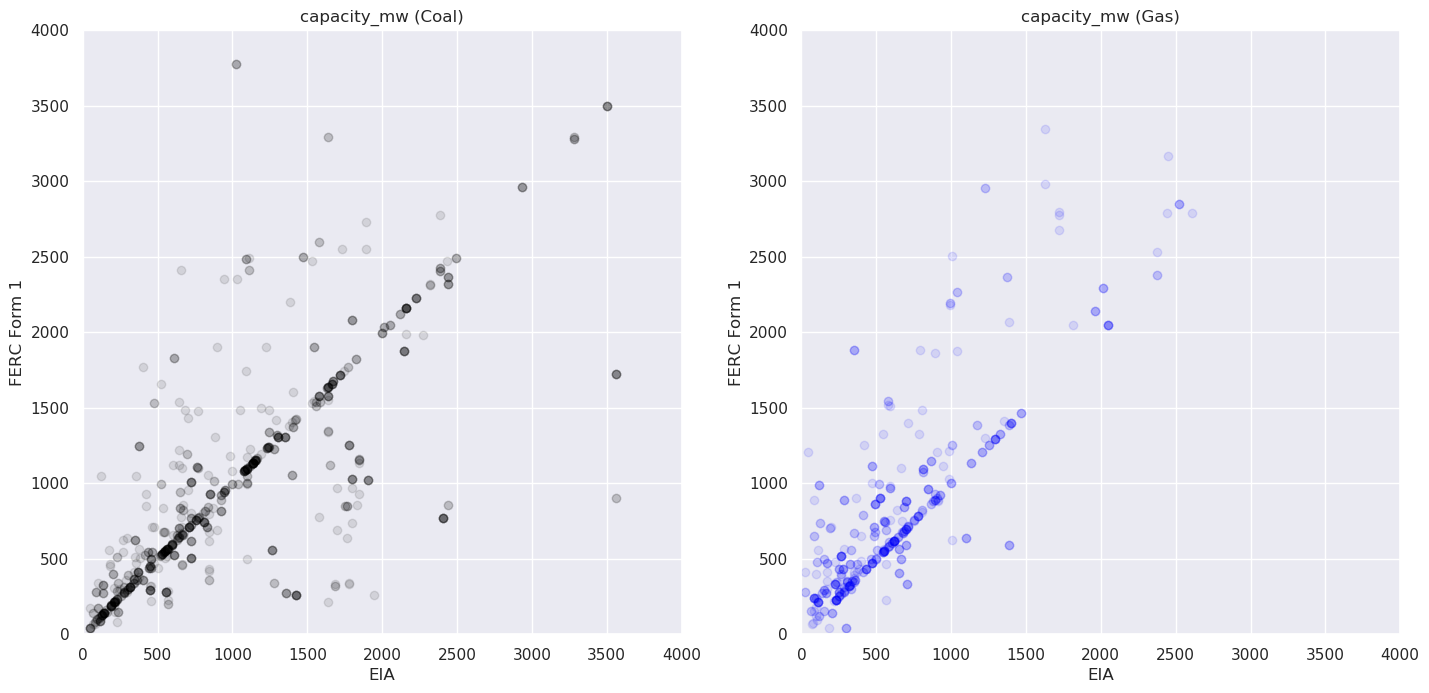

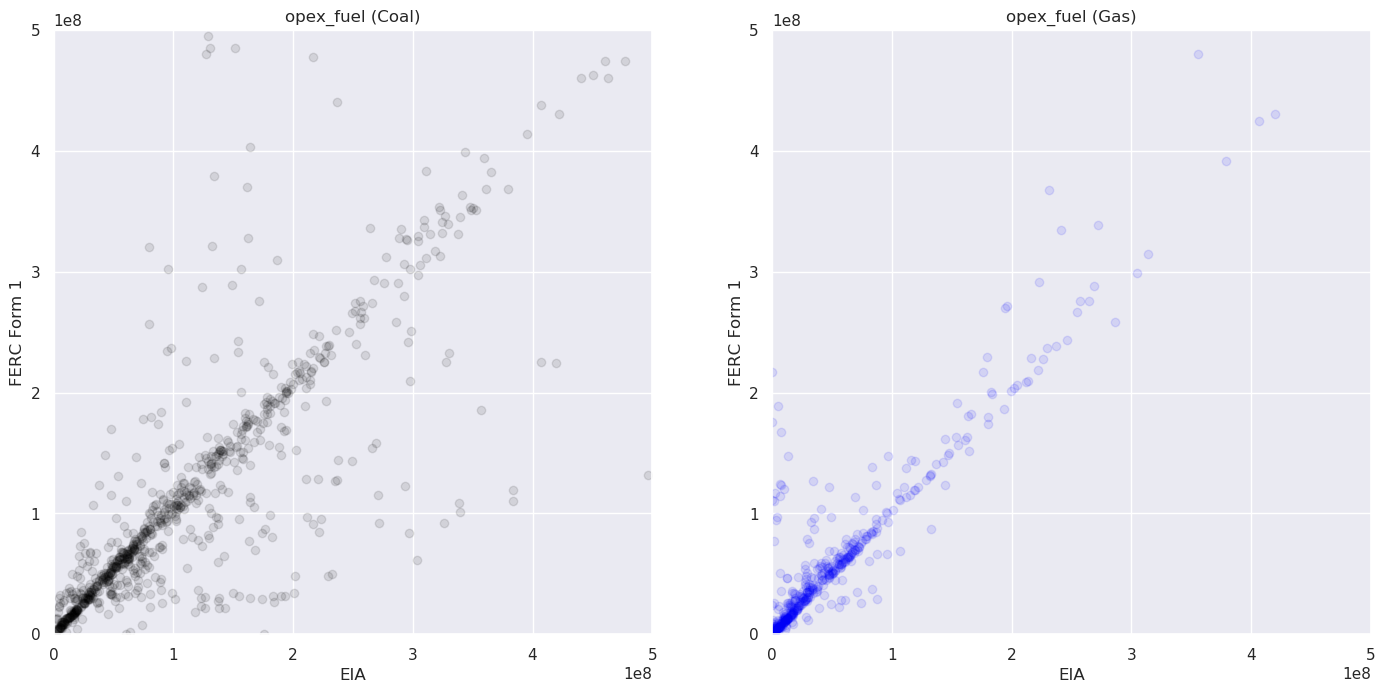

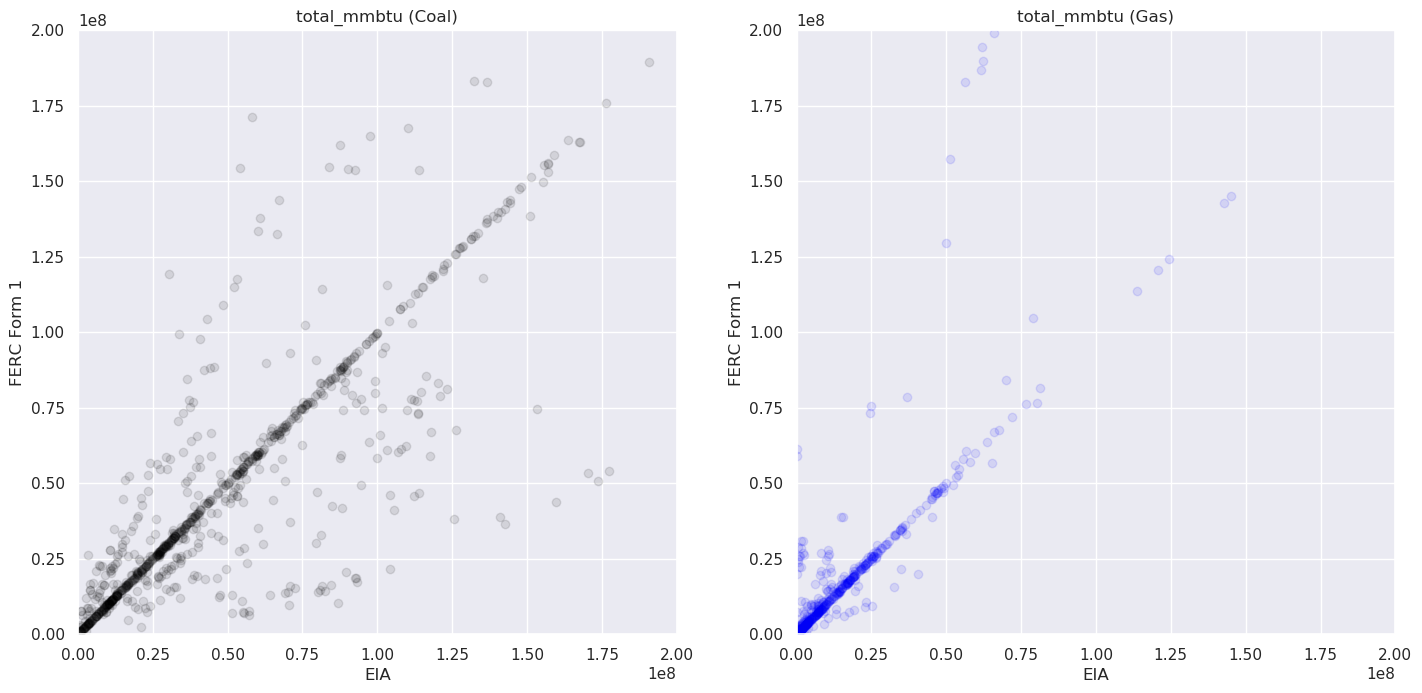

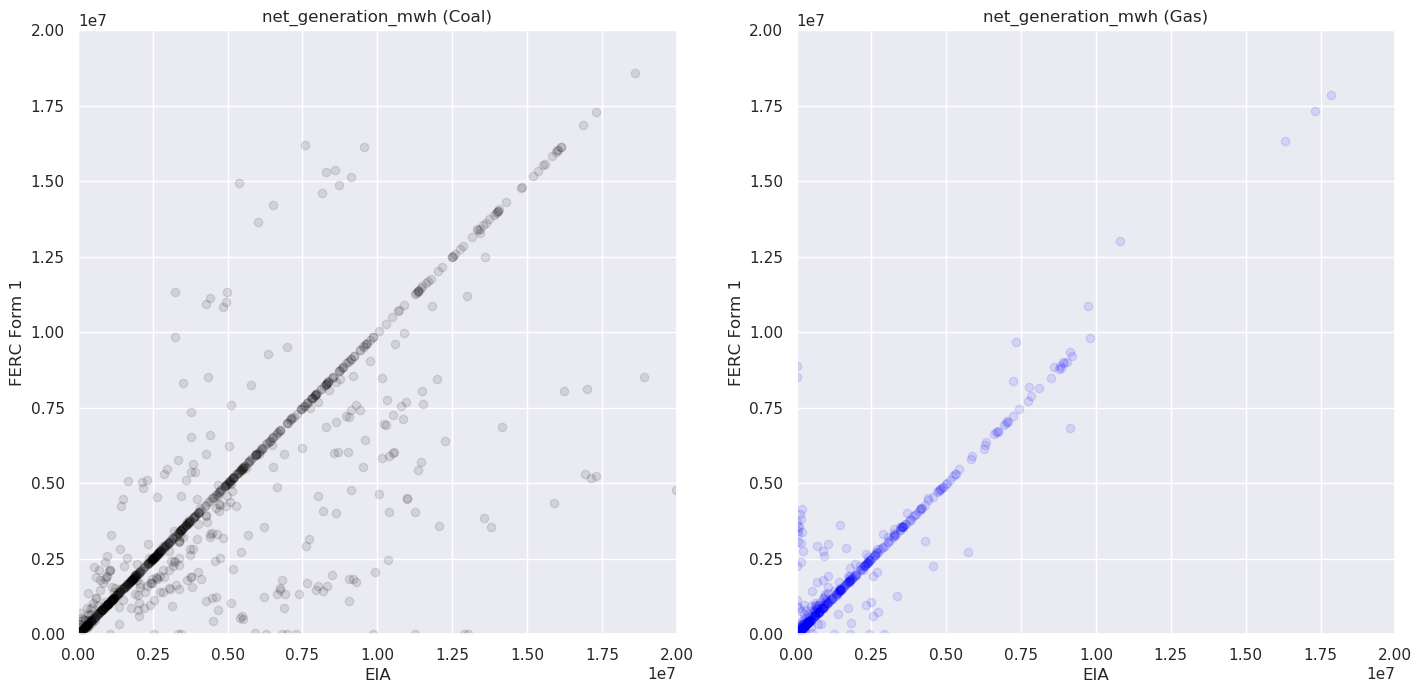

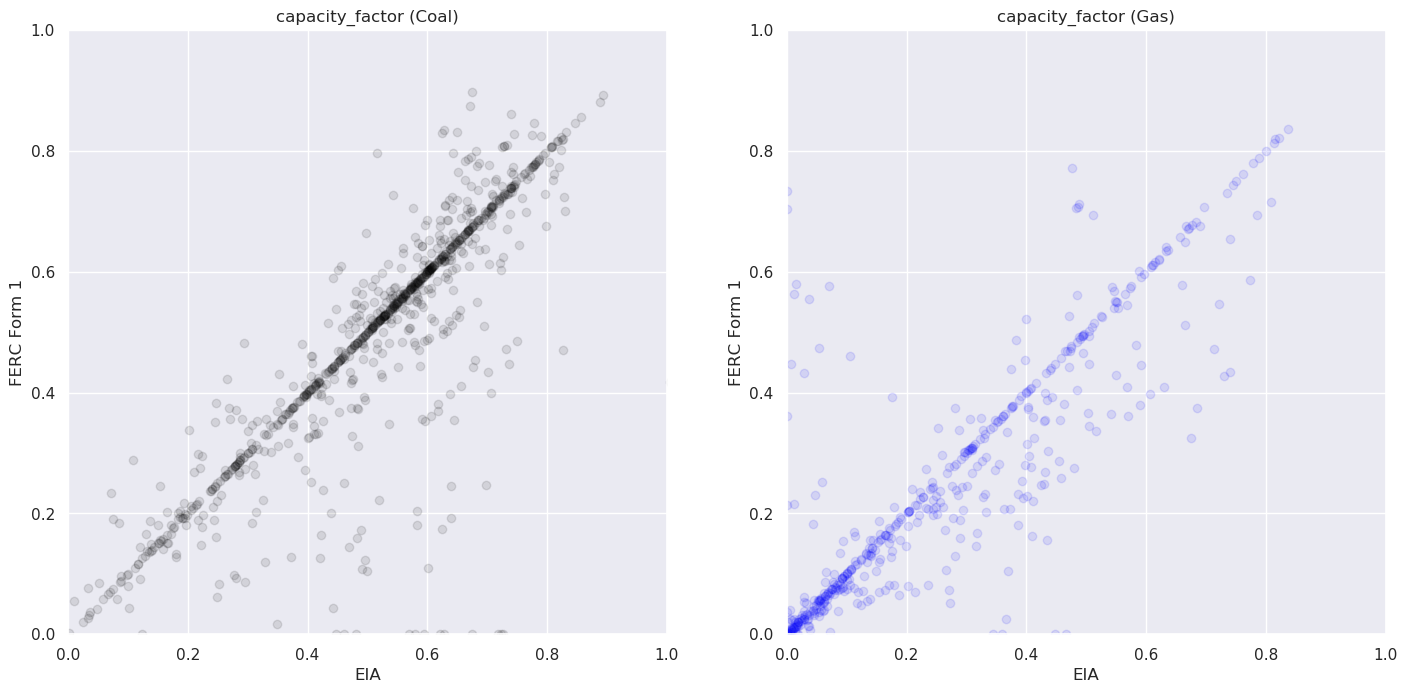

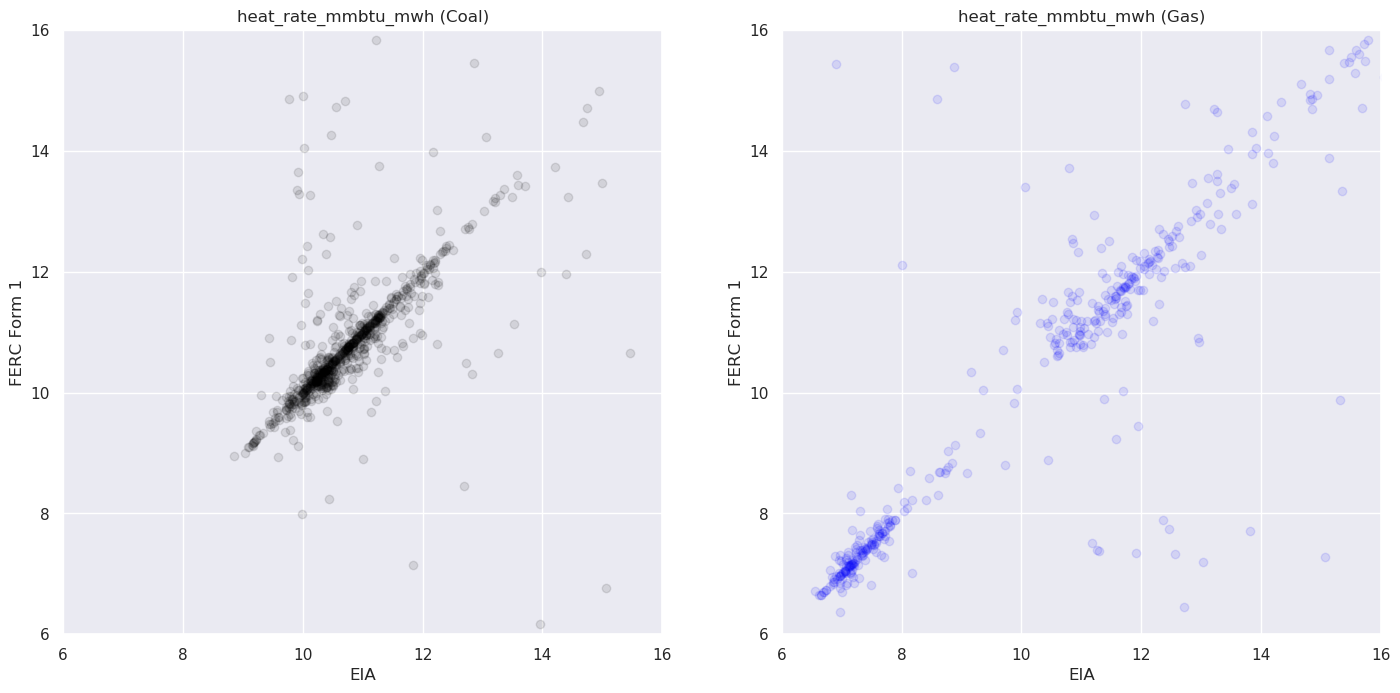

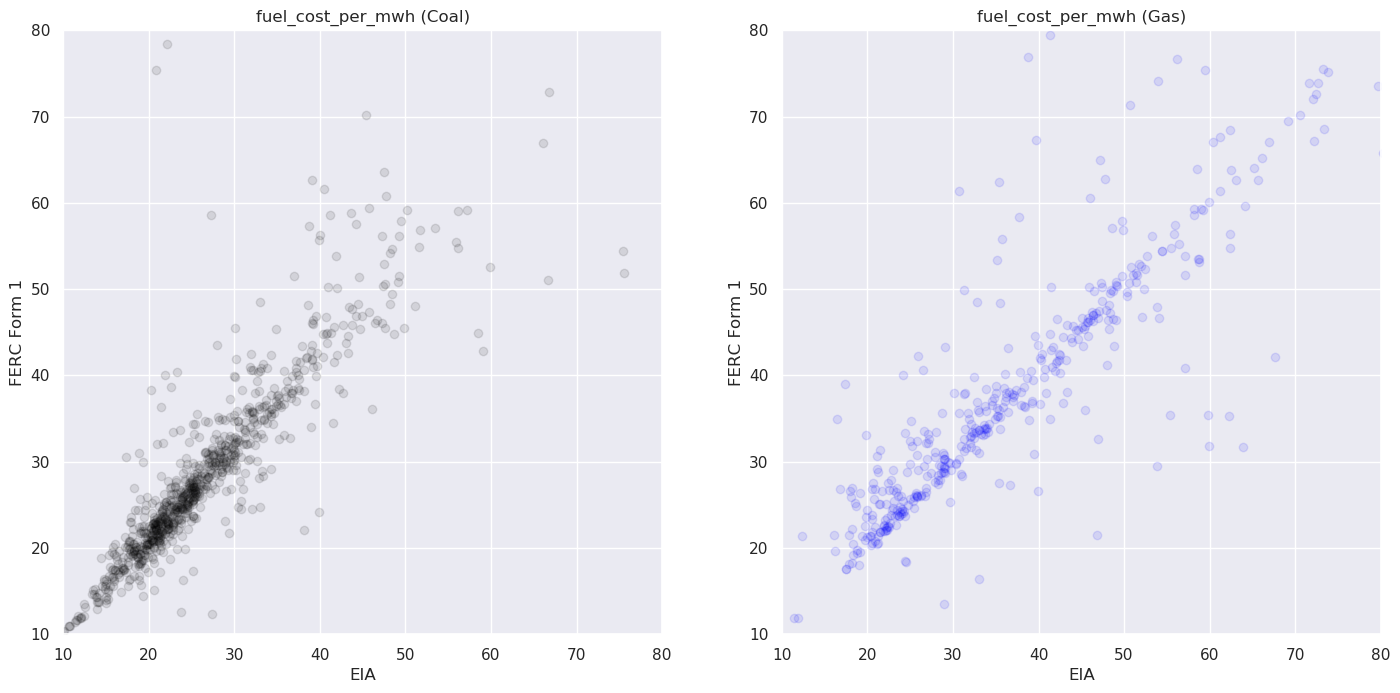

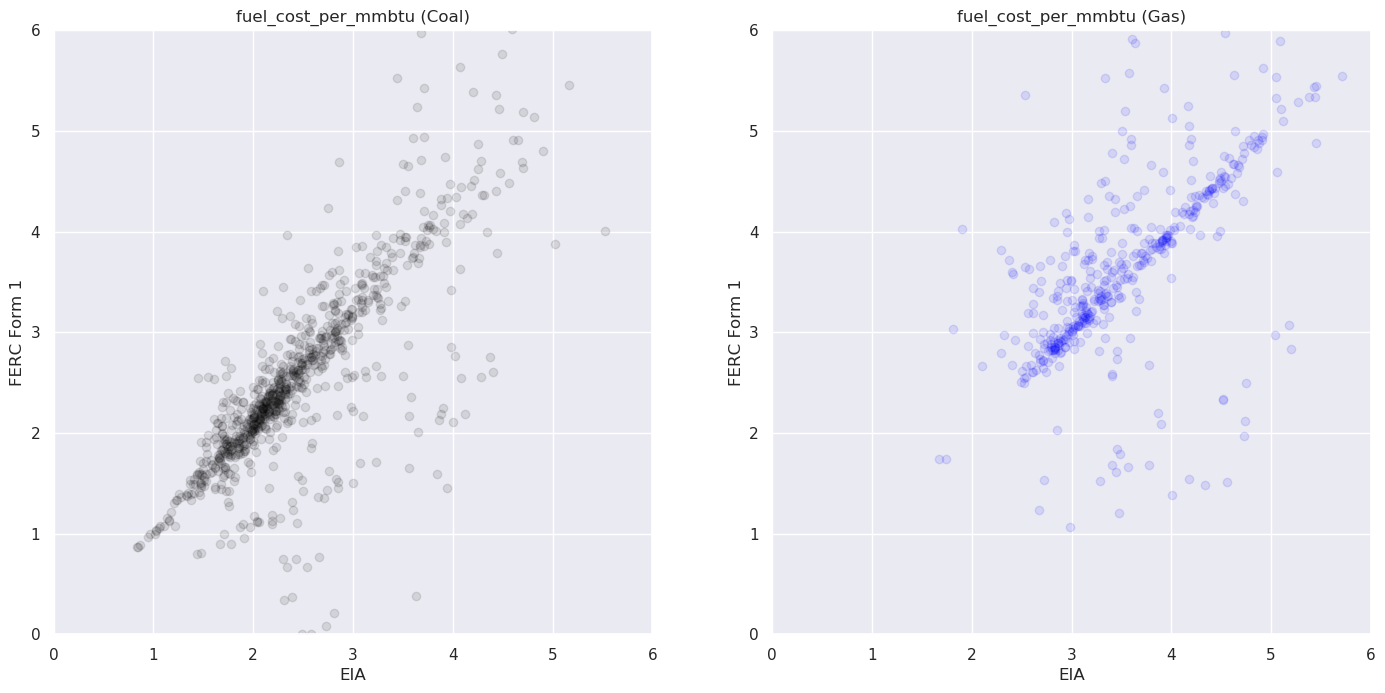

In [11]:
fields_to_plot = [
    # Simple Quantities
    'capacity_mw',
    'opex_fuel',
    'total_mmbtu',
    'net_generation_mwh',
    # Derived values
    'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mmbtu',
]

xy_limits = {
    # Simple Quantities
    'capacity_mw': (0,4000),
    'opex_fuel': (0,5e8),
    'total_mmbtu': (0,2e8),
    'net_generation_mwh': (0,2e7),
    # Derived values
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (0,6),
}

plot_eia_v_ferc1(pudl_dude, fields_to_plot, xy_limits)